In [5]:
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import binary_dilation
import json
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
from PIL import Image, ImageOps
from typing import Literal, List
import random
sys.path.append('../vinhdq_phucnph/CatVTON')
sys.path.append('../vinhdq_phucnph/CatVTON/model')
from model.cloth_masker import AutoMasker, MASK_DENSE_PARTS, MASK_CLOTH_PARTS, LIP_MAPPING, ATR_MAPPING, DENSE_INDEX_MAP
from model.mask_refiner import MaskRefiner
import os
from dataclasses import dataclass

In [6]:
from PIL import Image, ImageOps

def zoom_out_image(image, scale=0.8, background_color="white"):
    """
    Zoom out an image by scaling it down and adding padding.
    
    :param image_path: Path to the input image.
    :param output_path: Path to save the zoomed-out image.
    :param scale: Scale factor for zooming out (e.g., 0.8 for 80% of original size).
    :param background_color: Background color for padding.
    """

    original_size = image.size  # (width, height)

    # Calculate new dimensions for the image
    new_width = int(original_size[0] * scale)
    new_height = int(original_size[1] * scale)
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Create a padded image with the original dimensions
    padded_image = Image.new("RGB", original_size, background_color)
    paste_position = (
        (original_size[0] - new_width) // 2,
        (original_size[1] - new_height) // 2
    )
    padded_image.paste(resized_image, paste_position)

    return padded_image

In [7]:
from huggingface_hub import snapshot_download
repo_path = "zhengchong/CatVTON"
repo_path = snapshot_download(repo_id=repo_path)
automasker = AutoMasker(
    densepose_ckpt=os.path.join(repo_path, "DensePose"),
    schp_ckpt=os.path.join(repo_path, "SCHP"),
    device='cuda:0', 
)

Fetching 11 files: 100%|██████████| 11/11 [00:00<00:00, 72657.23it/s]


In [48]:
maskrefiner = MaskRefiner("mask_checkpoint/version4/mask3", device="cuda:0")

/home/jupyter/hungbd/image-background-remove-tool/carvekit/ml/wrap/tracer_b7.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_path, map_location=self.de

In [49]:
os.listdir("../datasets/DressCode/dresses/images")[:10]

['021647_1.jpg',
 '038144_1.jpg',
 '041168_0.jpg',
 '034451_0.jpg',
 '038195_1.jpg',
 '031539_0.jpg',
 '035648_1.jpg',
 '031386_1.jpg',
 '023960_1.jpg',
 '024013_1.jpg']

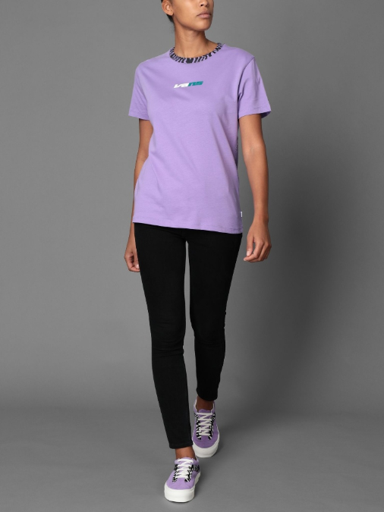

In [50]:
image = Image.open('../datasets/model2.png').resize((384, 512))
image

In [51]:
image = Image.open('../datasets/model2.png').convert("RGB").resize((384, 512))
auto_result = automasker(image, 'upper')

In [52]:
auto_result.keys()

dict_keys(['mask', 'densepose', 'schp_lip', 'schp_atr'])

In [53]:
person_image = "../datasets/model2.png"
cloth_image = "../datasets/outfit1.jpg"
person_image = Image.open(person_image).convert("RGB").resize((384, 512))
cloth_image = Image.open(cloth_image).convert("RGB").resize((384, 512))
cloth_image = zoom_out_image(cloth_image, 0.6)
refine_result = maskrefiner.predict_from_original(person_image, cloth_image, auto_result['mask'])

In [54]:
refine_result.keys()

dict_keys(['cloth_mask', 'pose_image', 'result'])

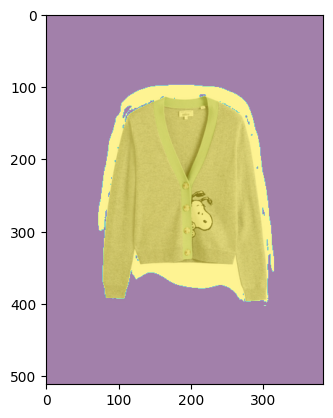

In [55]:
plt.imshow(cloth_image)
plt.imshow(refine_result['cloth_mask'], alpha=0.5)
plt.show()

In [56]:
a = np.array(refine_result['cloth_mask'])
a = a / a.max()

In [57]:
a.sum() / a.size * 100

np.float64(30.16204833984375)

In [58]:
final_result = automasker.create_refined_mask(person_image, refine_result['result'], mask_type="upper")

In [59]:
final_result.keys()

dict_keys(['result', 'weak_protect_area', 'body_protect_area', 'cloth_protect_area', 'strong_protect_area', 'accessory_protect_area'])

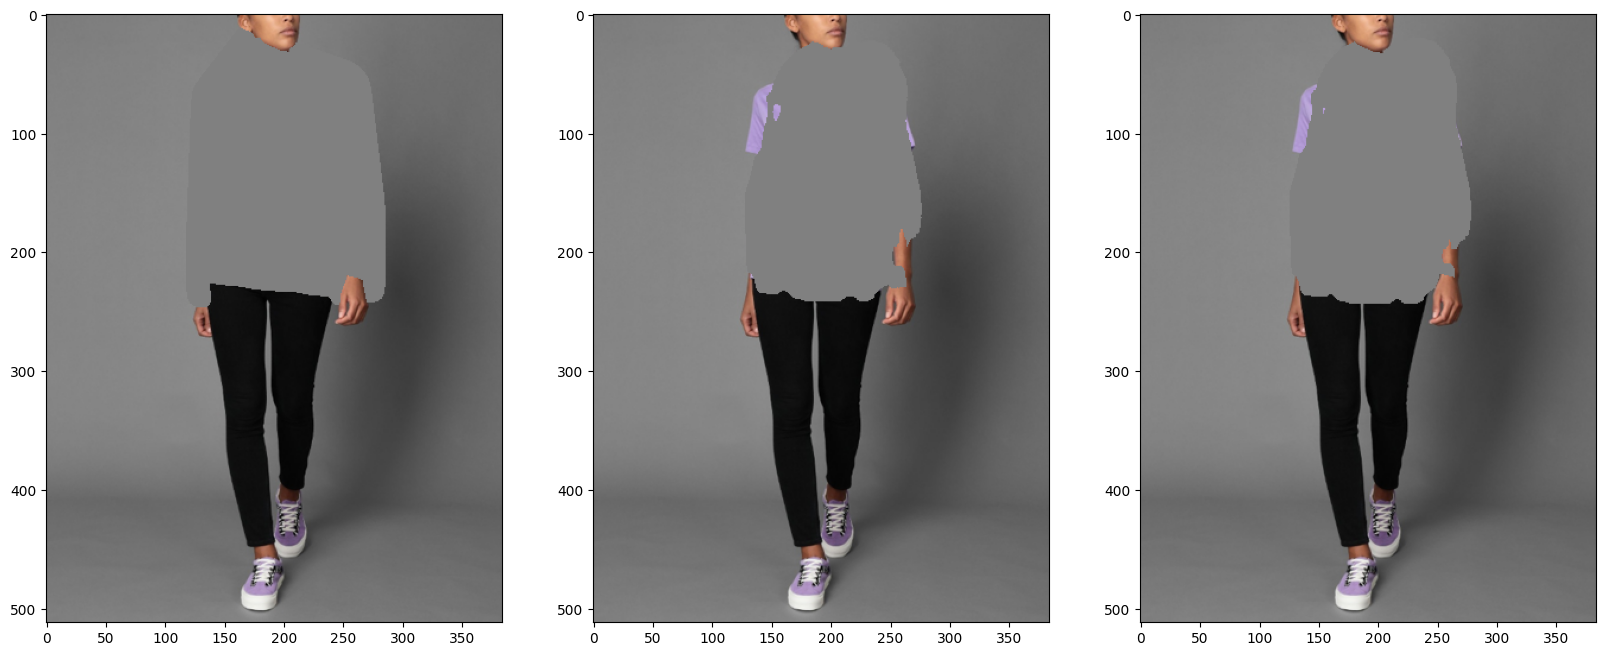

In [60]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
mask = auto_result['mask'].convert('L')
mask = np.array(mask)
tmp = np.array(person_image)
tmp[mask > 0] = [128, 128, 128]
tmp = Image.fromarray(tmp).convert("RGB")
plt.imshow(tmp)

plt.subplot(1, 3, 2)
mask = refine_result['result'].convert('L')
mask = np.array(mask)
tmp = np.array(person_image)
tmp[mask > 0] = [128, 128, 128]
tmp = Image.fromarray(tmp).convert("RGB")
plt.imshow(tmp)

plt.subplot(1, 3, 3)
mask = final_result['result'].convert('L')
mask = np.array(mask)
tmp = np.array(person_image)
tmp[mask > 0] = [128, 128, 128]
tmp = Image.fromarray(tmp).convert("RGB")
plt.imshow(tmp)
plt.show()

In [61]:
import matplotlib.image

def predict(person_image, cloth_image, category, image_size=(512, 384), device="cuda"):  
        
        h, w = image_size
        
        assert category in ["upper", "lower", "overall"]
        
        agnostic_mask_image = automasker(person_image, mask_type=category)['mask']
        
        pred_mask_image =  maskrefiner.predict_from_original(person_image, cloth_image, agnostic_mask_image, image_size=(512, 384), is_full=False)['result']
        
        final_result = automasker.create_refined_mask(person_image, pred_mask_image, mask_type=category)['result']
        
        mask = np.array(final_result.convert("L"))
        
        person_image = person_image.resize((w, h))
        person_image = np.array(person_image)
        person_image[mask == 1] = [128, 128, 128]
        person_image = Image.fromarray(person_image)
        
        return mask, person_image

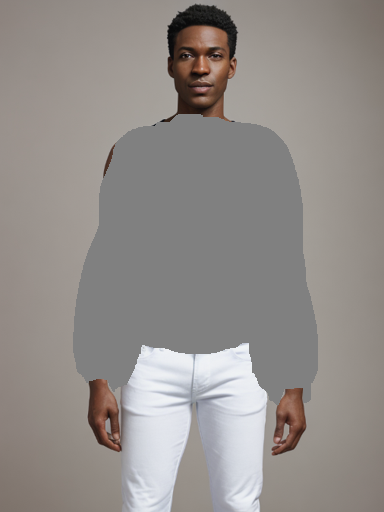

In [65]:
person_image = "../datasets/model3.png"
cloth_image = "../datasets/outfit1.jpg"
person_image = Image.open(person_image).convert("RGB").resize((384, 512))
cloth_image = Image.open(cloth_image).convert("RGB").resize((384, 512))
# cloth_image = zoom_out_image(cloth_image, 0.9)

predict(person_image, cloth_image, 'upper')[1]

/home/jupyter/hungbd/image-background-remove-tool/carvekit/ml/wrap/tracer_b7.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_path, map_location=self.de

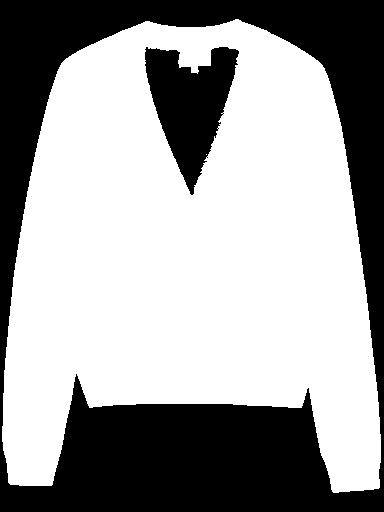

In [69]:
from model.target_cloth_masker import ClothMasker as TargetClothMasker
target_cloth_masker = TargetClothMasker()
a = target_cloth_masker(cloth_image)
a

In [72]:
a = np.array(a) / a.max()

In [73]:
a.sum() / a.size

np.float64(0.6267445882161459)

In [24]:
person_image = Image.open("../datasets/DressCode/dresses/images/041168_0.jpg")
cloth_image = Image.open("../datasets/DressCode/dresses/images/021647_1.jpg")
category = "overall"
predict(person_image, cloth_image, category)[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(512, 384), dtype=uint8)

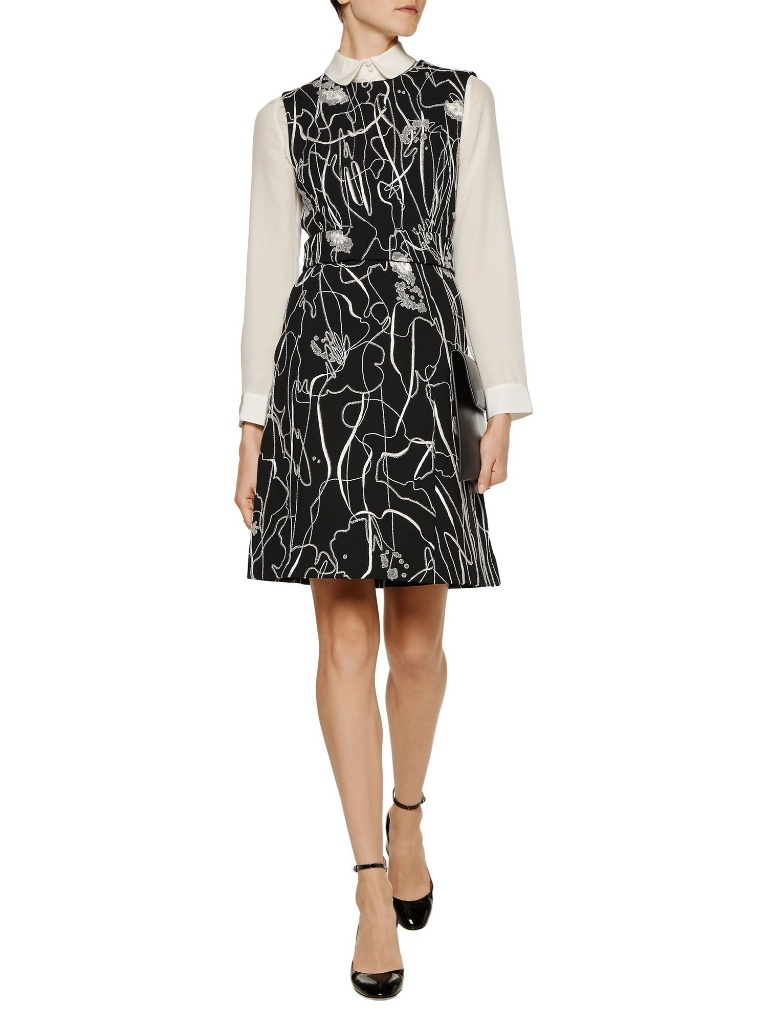

In [25]:
person_image